In [2]:
pip install wordcloud

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
import random
import re
import os

In [4]:
print("Tensorflow Version",tf.__version__)
df = pd.read_csv('IMDB Dataset.csv', encoding='latin', header=None)
df.head()

Tensorflow Version 2.18.0


,0,1
0,review,sentiment
1,One of the other reviewers has mentioned that ...,positive
2,A wonderful little production. <br /><br />The...,positive
3,I thought this was a wonderful way to spend ti...,positive
4,Basically there's a family where a little boy ...,negative


In [11]:
df.columns = [ 'text','sentiment']
df.head()

,text,sentiment
0,A wonderful little production. <br /><br />The...,positive
1,I thought this was a wonderful way to spend ti...,positive
2,Basically there's a family where a little boy ...,negative
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


In [13]:
lab_to_sentiment = {"negative":"Negative", "positive":"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,text,sentiment
0,A wonderful little production. <br /><br />The...,Positive
1,I thought this was a wonderful way to spend ti...,Positive
2,Basically there's a family where a little boy ...,Negative
3,"Petter Mattei's ""Love in the Time of Money"" is...",Positive
4,"Probably my all-time favorite movie, a story o...",Positive


Text(0.5, 1.0, 'Sentiment Data Distribution')

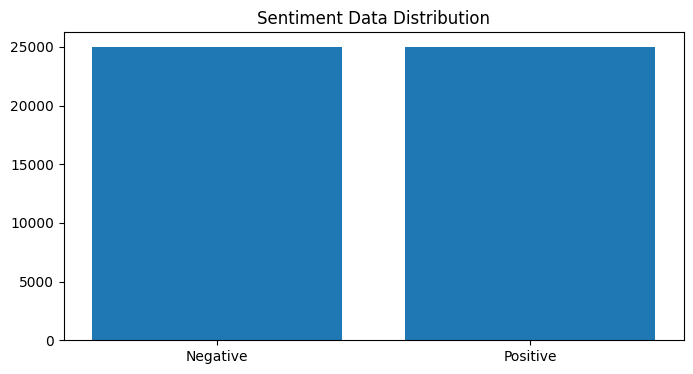

In [14]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [15]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10)

,text,sentiment
29890,"...Heads, Hands, and Feet - a band from the pa...",Positive
22464,"I have a high tolerance level for crap, so I w...",Negative
2023,I liked the understated character that Laura L...,Negative
37944,This brings back so many childhood memories. (...,Positive
44258,OK where do I start? I saw a screening a coupl...,Negative
30650,This Schiffer guy is a real genius! The movie ...,Positive
48605,"No real plot to this one, just a series of sho...",Negative
44625,This film is very creepy indeed. Unfortunately...,Negative
44826,"""Plants are the most cunning and vicious of al...",Negative
4703,I remember seeing this one in the theatres whe...,Positive


In [16]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
C:\Users\manik\AppData\Local\Temp\ipykernel_22228\3341848437.py:4: SyntaxWarning: invalid escape sequence '\S'
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


In [17]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [18]:
df.text = df.text.apply(lambda x: preprocess(x))

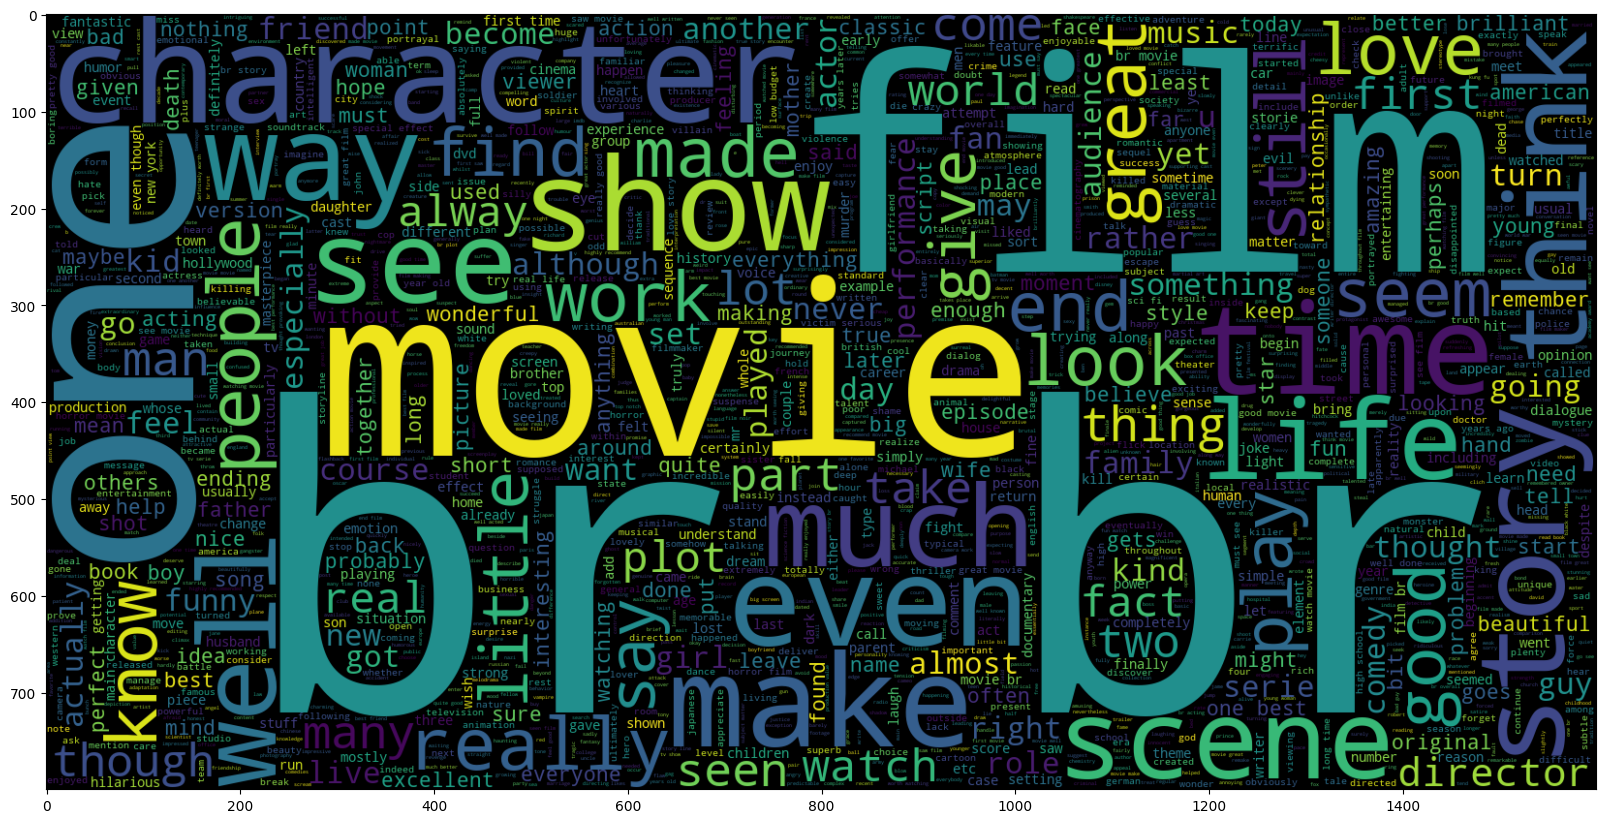

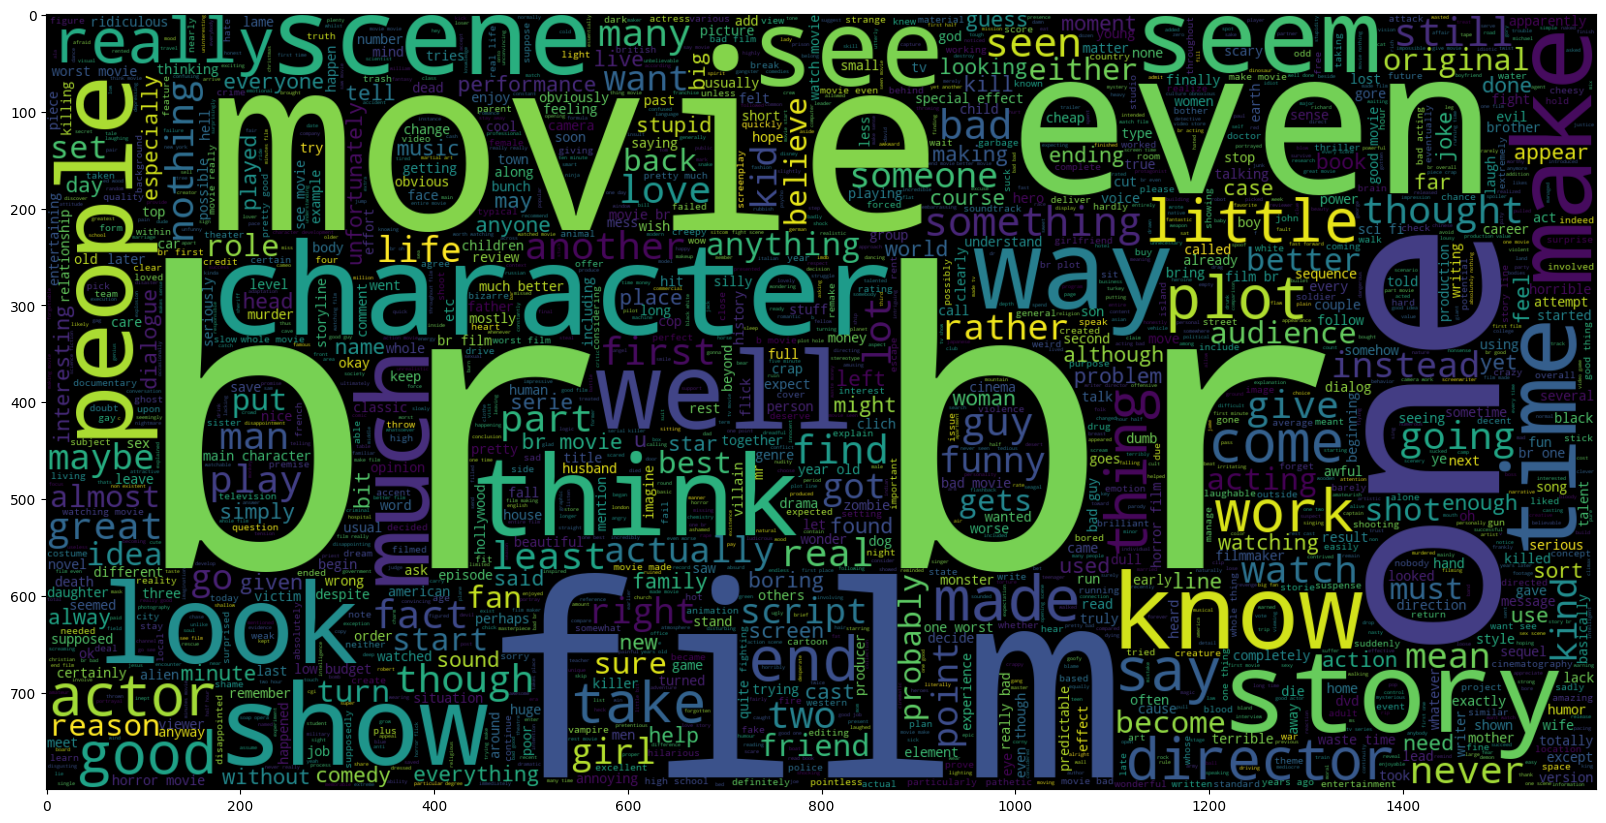

In [19]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')


plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [20]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30


In [21]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 39999
Test Data size 10000


In [22]:
labels = train_data.sentiment.unique().tolist()

In [23]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (39999, 1)
y_test shape: (10000, 1)


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 92155


In [25]:
import pickle

# Save the tokenizer to a file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [26]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (39999, 30)
Testing X Shape: (10000, 30)


In [27]:
print(x_test)

[[  210  1154     1 ...   719   784    15]
 [   39   962  1262 ... 21576    72   571]
 [ 1311 14634  5467 ...  1154  5854 35202]
 ...
 [    5     3   555 ...    52   555  3467]
 [ 5320   119 87492 ...   306    37 12178]
 [ 1262   435   100 ...  7603   493   247]]


In [28]:
import requests
import zipfile
import os

In [29]:
GLOVE_EMB = 'glove.6B.300d.txt'

EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'


In [35]:
embeddings_index = {}

f =  open(GLOVE_EMB,encoding='utf-8')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [36]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [37]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

c:\Users\manik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [39]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [40]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [41]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


In [42]:

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.6228 - loss: 0.6315 - val_accuracy: 0.7635 - val_loss: 0.4905 - learning_rate: 0.0010
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.7492 - loss: 0.5064 - val_accuracy: 0.7774 - val_loss: 0.4636 - learning_rate: 0.0010
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.7713 - loss: 0.4753 - val_accuracy: 0.7814 - val_loss: 0.4582 - learning_rate: 0.0010
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.7829 - loss: 0.4554 - val_accuracy: 0.7877 - val_loss: 0.4455 - learning_rate: 0.0010
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.8012 - loss: 0.4307 - val_accuracy: 0.8023 - val_loss: 0.4210 - learning_rate: 0.0010
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.8123 - loss: 0.4074 - val_accuracy: 0.8061 - val_loss: 0.4155 - learning_rate: 0.0010
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.8205 - loss: 0.3876 - 

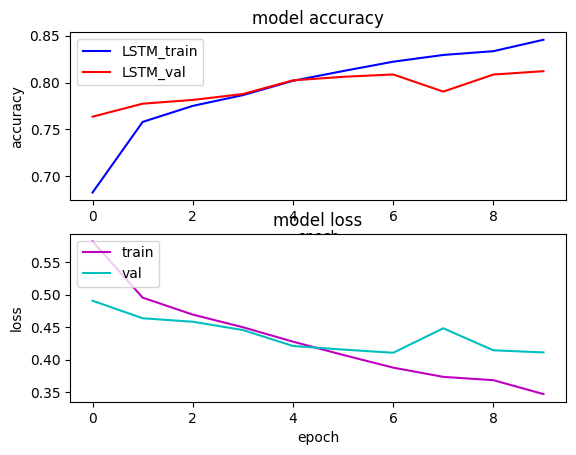

In [43]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [44]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [45]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

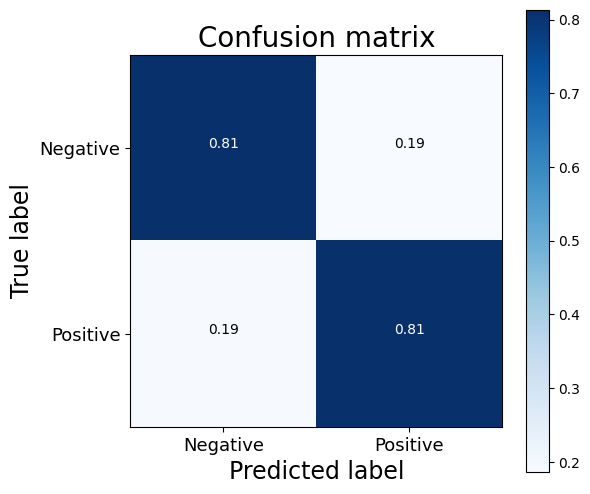

In [46]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [70]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.81      0.81      0.81      4924
    Positive       0.82      0.81      0.81      5076

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [48]:
df.shape

(49999, 2)

In [49]:
df['sentiment'].value_counts()

sentiment
Negative    25000
Positive    24999
Name: count, dtype: int64

In [50]:
from nltk.stem import PorterStemmer
port_steam = PorterStemmer()

In [51]:
def stemming(content):
    stemmer = nltk.SnowballStemmer('english')
    stemmed_content = content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [52]:
X = df['text'].values
Y = df['sentiment'].values

In [53]:
print(X)

['wonderful little production br br filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece br br actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life br br realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done'
 'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point 2 risk addiction thought proof woody allen still fully control style many us gr

In [57]:
print(X.shape, X_train.shape, X_test.shape)

(49999,) (39999,) (10000,)


In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [55]:
print(X_train)
print(Y_train)

['good schindler list found movie much powerful documentary based real life details story frank family anne particular although bit slow moving first detailing family life war becomes powerful br br due footage photos camps would recommend children adults illustrates horror holocaust one young girl highly recommended'
 'thought different compared modern interpretations shakespeare enjoyed thoroughly would useful studying school etc show traditional shakespeare character interpretations e miranda portrayed quite punky compared traditional shakespeare lady understanding play basis story strong piece fantastic watch include also correct format layout acts scenes currently playing miranda production lines cut scenes split mixed around useful would definitely recommend must see even say seen shakespeare fans would love'
 'ended watching movie even going reviews request female curiosity thought let find people actually recommend others watch movie quite shocked find long positive reviews web

In [56]:
print(X_train)

['good schindler list found movie much powerful documentary based real life details story frank family anne particular although bit slow moving first detailing family life war becomes powerful br br due footage photos camps would recommend children adults illustrates horror holocaust one young girl highly recommended'
 'thought different compared modern interpretations shakespeare enjoyed thoroughly would useful studying school etc show traditional shakespeare character interpretations e miranda portrayed quite punky compared traditional shakespeare lady understanding play basis story strong piece fantastic watch include also correct format layout acts scenes currently playing miranda production lines cut scenes split mixed around useful would definitely recommend must see even say seen shakespeare fans would love'
 'ended watching movie even going reviews request female curiosity thought let find people actually recommend others watch movie quite shocked find long positive reviews web

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
print(type(X_train))

<class 'numpy.ndarray'>


In [60]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [61]:
print(X_test)

  (0, 255)	0.17546764989591912
  (0, 1544)	0.04046493065223585
  (0, 2636)	0.0504367188651509
  (0, 2917)	0.05962845557177598
  (0, 3173)	0.079878429350489
  (0, 3360)	0.07392558742573017
  (0, 4316)	0.10507485590522314
  (0, 4392)	0.074803026849329
  (0, 6577)	0.04955419825545198
  (0, 6639)	0.025511263155451037
  (0, 7770)	0.0759991542040328
  (0, 7832)	0.03791019669832483
  (0, 7836)	0.05330632010268493
  (0, 8592)	0.027538451488942284
  (0, 9418)	0.07784302883763998
  (0, 10644)	0.09605038516420021
  (0, 11139)	0.059925383081407275
  (0, 11879)	0.0796760647281029
  (0, 12565)	0.039819726835171425
  (0, 12759)	0.04454257521484827
  (0, 13398)	0.032079749639868795
  (0, 13910)	0.1040057548387162
  (0, 14116)	0.04423733681444598
  (0, 14154)	0.06187374162732067
  (0, 14219)	0.055347945824552866
  :	:
  (9999, 54385)	0.057203296035449255
  (9999, 55861)	0.06593471626694053
  (9999, 57501)	0.09911519156728409
  (9999, 58159)	0.17698056243351654
  (9999, 59737)	0.10812265378798731
  (999

In [62]:
print(X_train)

  (0, 34322)	0.061669336387938596
  (0, 71152)	0.25425313143227274
  (0, 47830)	0.152913627923751
  (0, 31338)	0.10672807362217672
  (0, 54257)	0.04680780856240094
  (0, 54385)	0.07103329685372561
  (0, 62999)	0.3036061197369709
  (0, 23644)	0.14603780314436807
  (0, 7407)	0.12463079304485435
  (0, 66111)	0.09152853117767526
  (0, 47469)	0.17010665489166568
  (0, 21954)	0.16316014157439407
  (0, 77896)	0.0693557684933926
  (0, 31503)	0.16758367943147295
  (0, 28867)	0.2209845260231761
  (0, 4158)	0.18363792424579053
  (0, 59732)	0.14552740518853716
  (0, 3409)	0.10845306833647779
  (0, 9127)	0.1034451697269536
  (0, 74866)	0.13342192939232705
  (0, 54293)	0.1403502849424027
  (0, 30186)	0.07456569376688087
  (0, 21953)	0.2498248459713619
  (0, 88580)	0.12561007192747123
  (0, 7891)	0.1280554829235519
  :	:
  (39997, 46097)	0.13578329185989757
  (39997, 37018)	0.14324630179068704
  (39998, 54257)	0.05900992019040791
  (39998, 54782)	0.12520892401290984
  (39998, 71958)	0.083831311507535

In [63]:
import pickle

# Save the model
filename = 'trained_movie_model.sav'
pickle.dump(model, open(filename, 'wb'))



In [64]:
# loading the saved model
loaded_model = pickle.load(open('trained_movie_model.sav', 'rb'))

In [65]:
def preprocess(text, stem=False):
    text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\manik\AppData\Local\Temp\ipykernel_22228\1460555962.py:2: SyntaxWarning: invalid escape sequence '\S'
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


In [66]:
custom_text = "I really love this product! It’s amazing."

# Preprocess the text
cleaned_text = preprocess(custom_text)

# Tokenize and pad the text
custom_text_sequence = tokenizer.texts_to_sequences([cleaned_text])  # Tokenize
custom_text_padded = pad_sequences(custom_text_sequence, maxlen=MAX_SEQUENCE_LENGTH)  # Pad

In [67]:
score = model.predict(custom_text_padded)

# Decode the sentiment
predicted_sentiment = decode_sentiment(score[0][0])

# Output the result
print(f"Custom Text: {custom_text}")
print(f"Predicted Sentiment: {predicted_sentiment} (Score: {score[0][0]})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Custom Text: I really love this product! It’s amazing.
Predicted Sentiment: Positive (Score: 0.9000356197357178)


In [68]:
# Load the tokenizer from the file
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

def predict_sentiment(custom_text, tokenizer, model, max_sequence_length=50):
    # Preprocess the input text
    cleaned_text = preprocess(custom_text)

    # Tokenize and pad the input text to match model input
    custom_text_sequence = tokenizer.texts_to_sequences([cleaned_text])
    custom_text_padded = pad_sequences(custom_text_sequence, maxlen=max_sequence_length)

    # Predict sentiment
    score = model.predict(custom_text_padded)

    # Decode the sentiment
    pos_score = score[0][0]
    neg_score = 1 - score[0][0]

    positive_percent =  pos_score * 100
    negitive_percent =  neg_score * 100

    def decode_sentiment(score):
        return "Positive" if score > 0.5 else "Negative"

    predicted_sentiment = decode_sentiment(score[0][0])

    # Output the result
    return {
        'custom_text': custom_text,
        'predicted_sentiment': predicted_sentiment,
        'positive_percent': positive_percent,
        'negitive_percent' : negitive_percent
    }

In [69]:
# custom_input = "The product arrived on time, and the packaging was great, but it doesn’t work as advertised. Really disappointed. 😕 #MixedFeelings"
custom_input ="i love you my country"
result = predict_sentiment(custom_input, tokenizer, model)
 
print(f"input: {result['custom_text']}")
print(f"output: {result['predicted_sentiment']}")
print(f"Percent positive : {result['positive_percent']:.2f}%")
print(f"Percent negative : {result['negitive_percent']:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
input: i love you my country
output: Positive
Percent positive : 89.04%
Percent negative : 10.96%
